# Moving From Regression to Classification

Previously, we've created several regression models to predict the final grade for our students.

We saw that once we removed G1 and G2 grades, it became much more difficult to predict their final score.

Since we cannot trust our models' predictions, we cannot trust the insights/explanations we extract from the model.

Our stakeholder's goal is to identify at-risk students
before their final grade in order to intervene and provide additional support to those students. The stakeholder never said that they need to know the EXACT GRADE for each student.


In this situation, it makes perfect sense to convert this task into a classification that better addresses our stakeholder business case.

# Functions

In [1]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [2]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [3]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [4]:
# function to get coefficients
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [5]:
# function to plot
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False,  intercept_name = "intercept",annotate=False, ha='left',va='center', size=12, xytext=(4,0), textcoords='offset points'):
  """Plots the top_n coefficients from a Series, with optional annotations."""
# Drop intercept if intercept=False and 
  if (intercept==False) & ( intercept_name in coeffs.index):
    coeffs = coeffs.drop(intercept_name)
  if top_n==None:
    ## sort all features and set title
    plot_vals = coeffs#.sort_values()
    title = "All Coefficients - Ranked by Magnitude"
  else:
    ## rank the coeffs and select the top_n
    coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
    top_n_features = coeff_rank.head(top_n)
## sort features and keep top_n and set title
    plot_vals = coeffs.loc[top_n_features.index].sort_values()
    title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    ## annotating bar values 
  if annotate==True:
    annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    return ax

In [6]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [7]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

# Import 

In [54]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display='text')
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)


# Import shap and initialize javascript:
import shap
shap.initjs()



# Plot Styles

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'



# Preprocessing

In [10]:
## Load in the student performance - Portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


After talking with our stakeholder, we've agreed that predicting which students will receive an F would be the most effective target.

# Calculating Letter Grades from G3

In [11]:
## convert G3 to a % out of 100
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()



0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

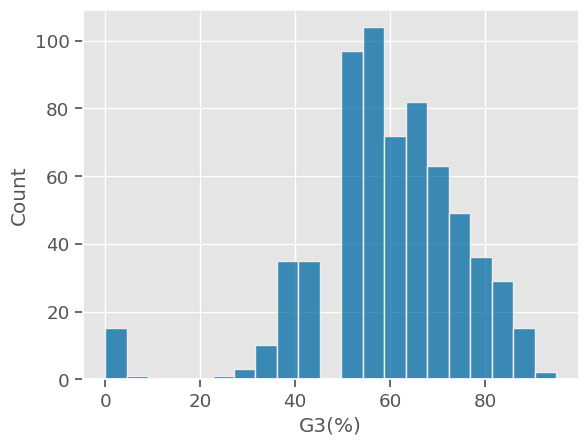

In [12]:
## visual distribution of % grades
ax = sns.histplot(data=df, x='G3(%)')



In [13]:
## defining bin edges
bins = [0,60,70,80,90,100]
grades = pd.cut(df['G3(%)'], bins=bins)
grades.value_counts().sort_index()



(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

But we want to include 0 in the bin and DON'T want to include 60. We want the logic to be 0<=x<60 

In [14]:
gbins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()




[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

In [15]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [16]:
# add these values to our DataFrame as a new column 'FinalGrade'.
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df



,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,55.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,55.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,60.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,70.0,D
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,10,11,10,50.0,F
645,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,15,15,16,80.0,C
646,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,11,12,9,45.0,F
647,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6,10,10,10,50.0,F


In [17]:
## We can group by the letter grades and get the min/max of the scores to confirm 
df.groupby('FinalGrade')['G3(%)'].agg(['min','max','count'])



,min,max,count
FinalGrade,,,
F,0.0,60.0,373
D,65.0,70.0,145
C,75.0,80.0,85
B,85.0,90.0,44
A,95.0,95.0,2


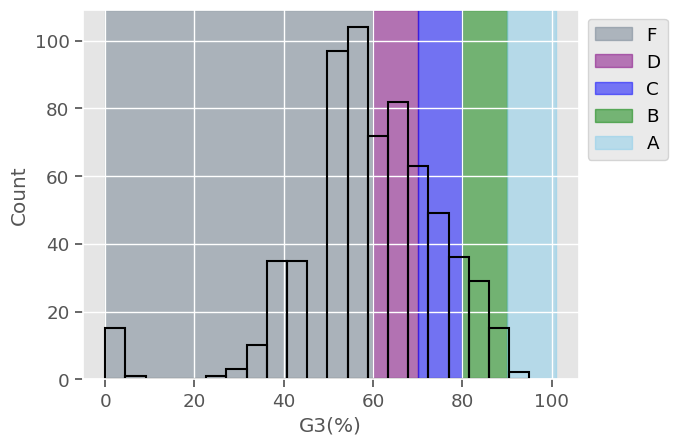

In [18]:
## visualizing the cutoffs for grades
ax = sns.histplot(data=df, x='G3(%)',color='k',fill=False)
colors = ['slategray','purple','blue','green','skyblue']
for i in range(len(bins)-1):
    x1 = bins[i]
    x2 = bins[i+1]
    label = bin_labels[i]
    ax.axvspan(x1,x2, label=label,color=colors[i],zorder=0,alpha=.5)
ax.legend(bbox_to_anchor=[1,1])



We can also view these distributions on two separate graphs.

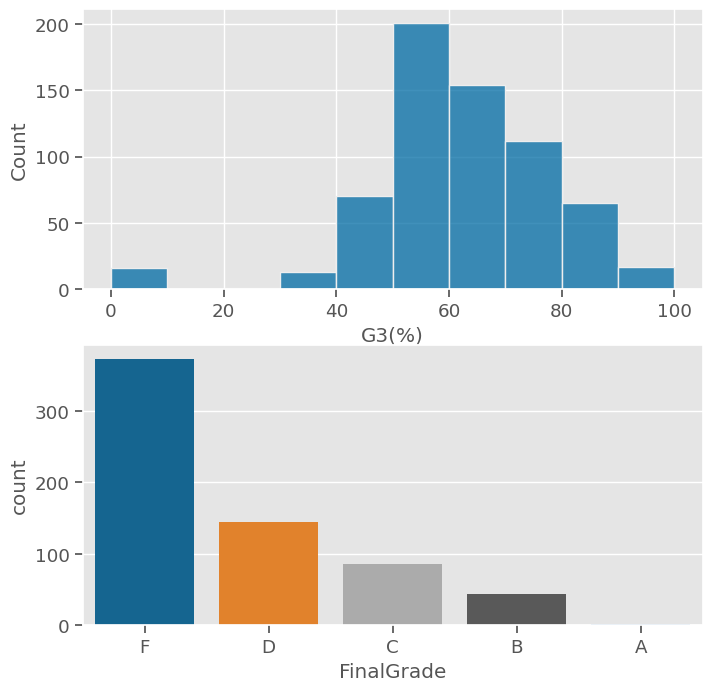

In [19]:
fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10);
sns.countplot(data=df,x='FinalGrade',ax=axes[1],order=['F','D','C','B','A']);


# Making Our Final Target & X/y Data

Since we are interested in creating a binary classification. We will define a new column that simply indicates whether a student received an F (failed) or not (passed). We will also check the class balance by using value_counts(normalize=True).

In [20]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(normalize=True)



True     0.57473
False    0.42527
Name: target_F, dtype: float64

In [21]:
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)


In [22]:
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                     fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


# RandomForestClassifier

## Function for Evaluating Classification Models

In [23]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()



--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



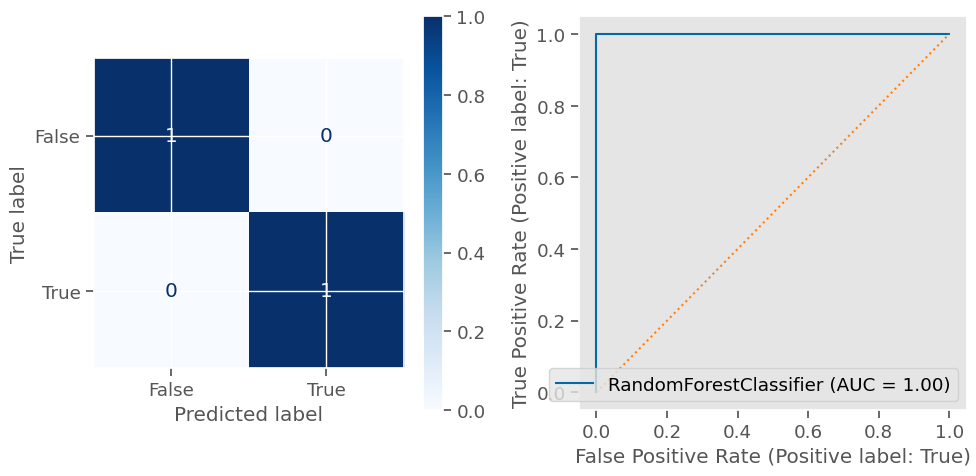

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



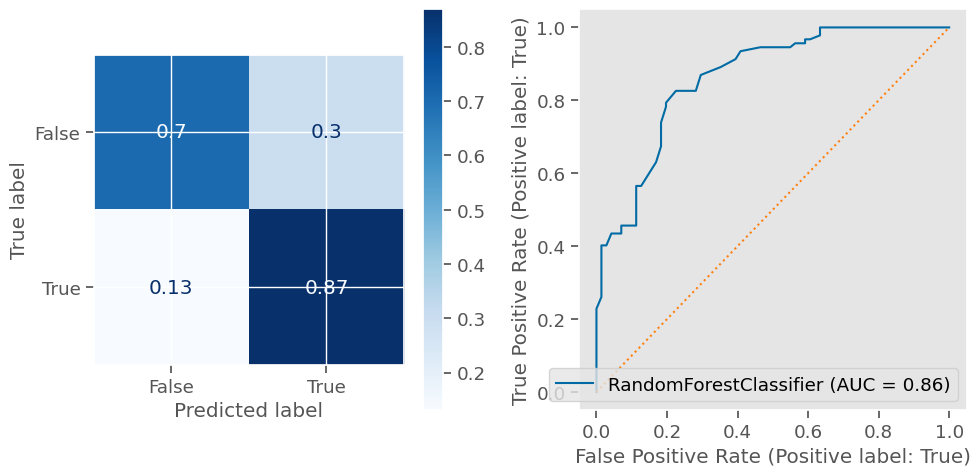

In [24]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()#class_weight='balanced')
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)



We have an overall accuracy of .80, which isn't bad. However, our task is to identify the students who will get an F (the True group). So let's take a closer look at our True class scores.

The Recall score for True is .87. This means that out of all of the students who will fail, our model is identifying 87% of them correctly. While this isn't perfect (there are still 13% of students who will fail that are falling through the cracks), this is MUCH better than our R-squared of 0.35!

As we can see above, our classification task is performing much better than our regression version of the task! This is a much more appropriate model to extract insights from.

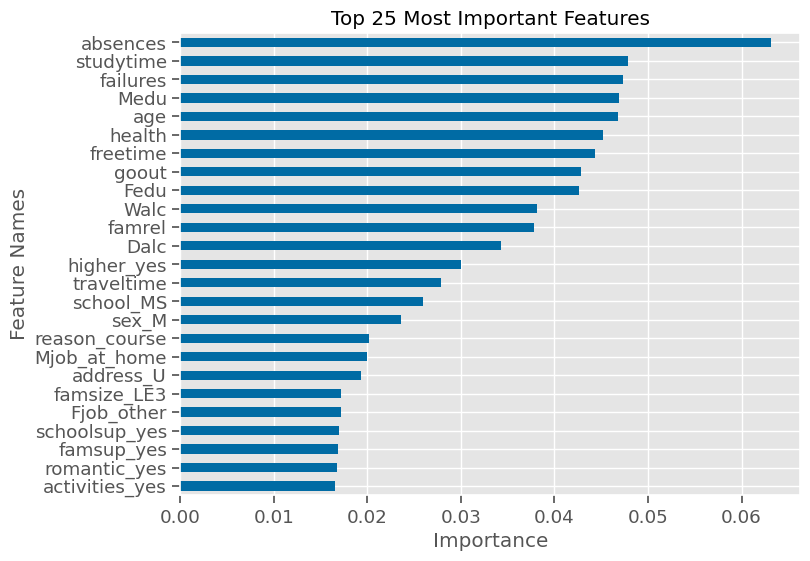

In [25]:
rf_importances = get_importances(rf_clf)
ax = plot_importance(rf_importances,top_n=25)



As we can see above, absences, studytime, failures, Medu, and age are the most important features, with many other features not too far behind.

As we discussed previously, built-in feature importances are biased towards considering numeric features as more important, so let's compare these importances to our Permutation Importance

## Permutation Importances - RandomForest

In [26]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()



dict_keys(['importances_mean', 'importances_std', 'importances'])

In [27]:
## getting the colors for the top 7 important rf features
colors_rf = get_color_dict(rf_importances,top_n=7)



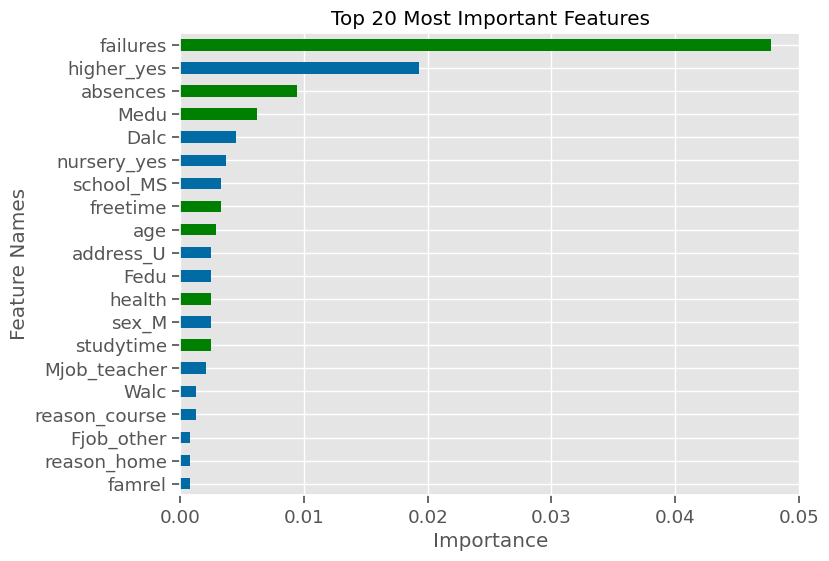

In [28]:
## can make the mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
plot_importance_color_ax(rf_perm_importances,color_dict=colors_rf,top_n=20);



As we can see above, one of the features with the top 3 largest permutation importance were not in the random forest's top features:

higher_yes

As we previously discussed, built-in feature importance often overlooks categorical features. Our permutation importance, however, avoids this bias and it determined 1 out of the 3 most important features to be a categorical feature.

Also, as we discussed previously, neither feature importance nor permutation importance tells us the directionality of that feature vs the target.

higher_yes means that the student is planning to pursue higher education. We may suspect that being in this group leads to decreased likelihood of Failing, but we cannot say that for sure with just this information.

## Post-Modeling EDA

Let's combine all of our processed data back into 1 DataFrame for our final EDA.

This means we want to combine:
    
X_train and y_train (first),

X_test and y_test (second),

and then combine both of the above!

In [29]:
# Combining all data for eda post-modeling
plot_df_train = pd.concat([X_train_df, y_train],axis=1)
plot_df_test = pd.concat([X_test_df, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,target_F
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,True
547,16.0,4.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
604,18.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,17.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
454,16.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,True
56,15.0,4.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,False
203,17.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,3.0,1.0,5.0,3.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True


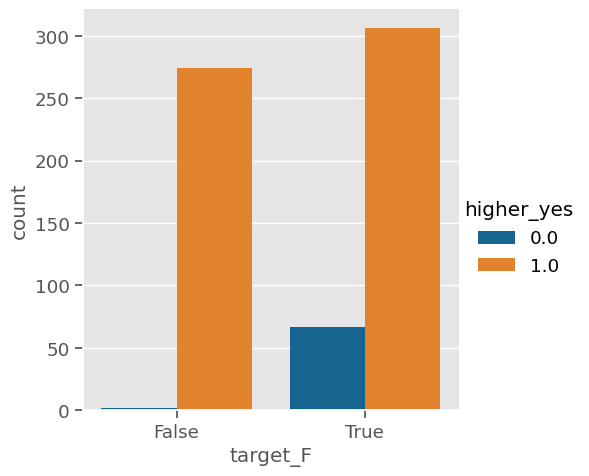

In [30]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='higher_yes');



As we can see with our EDA above, it looks like there are a higher proportion of students that are NOT pursuing higher education (blue group) in the Failing students (target_F==True) than the successful students.

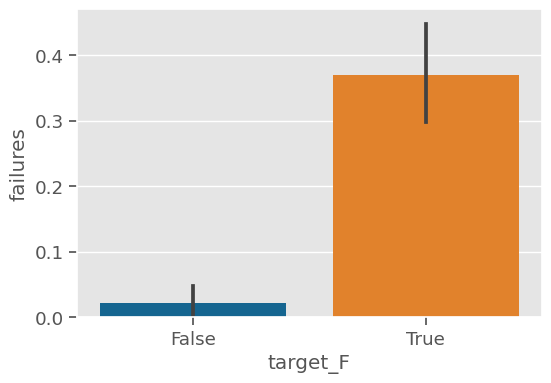

In [31]:
plt.figure(figsize=(6,4))
ax = sns.barplot(data=plot_df, x='target_F',y='failures')



We can see above that students who failed Portuguese had many more failures, on average.

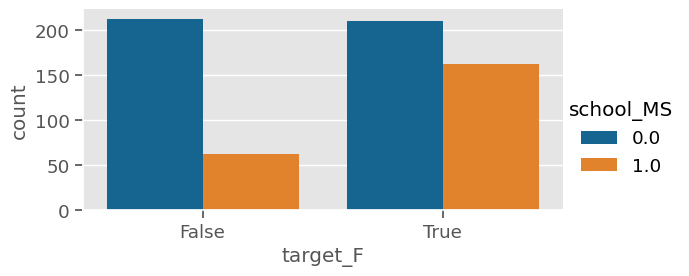

In [32]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='school_MS',
            aspect=2, height=3);



# LogisticRegression in sklearn

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       0.73      0.71      0.72       205
        True       0.79      0.81      0.80       281

    accuracy                           0.77       486
   macro avg       0.76      0.76      0.76       486
weighted avg       0.76      0.77      0.76       486



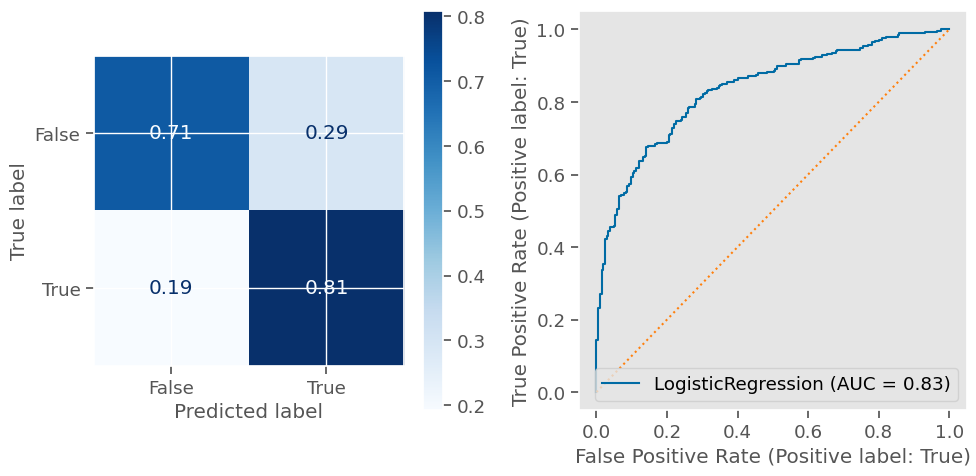

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.73      0.69      0.71        71
        True       0.77      0.80      0.79        92

    accuracy                           0.75       163
   macro avg       0.75      0.75      0.75       163
weighted avg       0.75      0.75      0.75       163



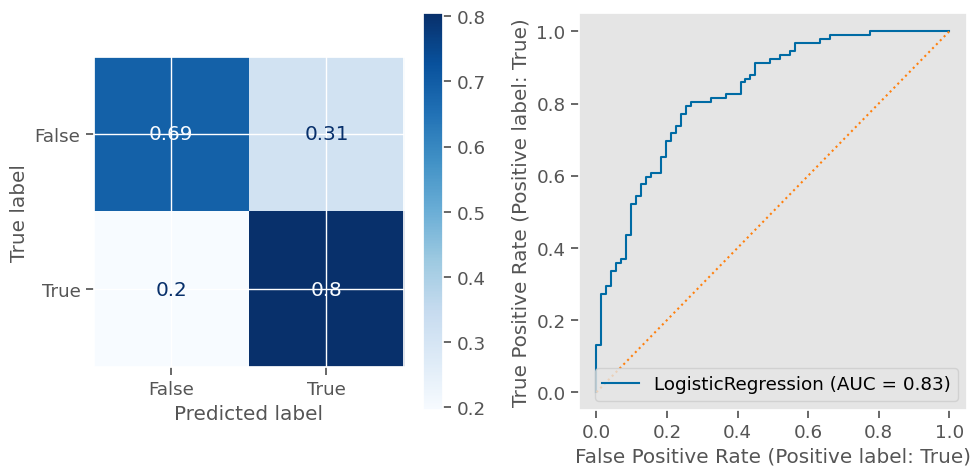

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_df, y_train)
evaluate_classification(logreg,X_train_df,y_train, X_test_df,y_test)



As we can see above, our LogisticRegression model did not perform quite as well as our RandomForest, but it is still performing well-enough that it is worth extracting our coefficients and getting additional insights into the directionality of the effect of each feature on the target.

## Extracting Coefficients from LogisticRegression in scikit-learn

Both scikit-learn Linear Regressions & Logistic Regressions calculate coefficients.
However, logistic regression models will return more than 1 set of coefficients if you are predicting more than 2 classes.
Let's try to use our previous get_coeffs function on the logistic regression model.

In [34]:
try:
    get_coeffs_linreg(logreg)
except Exception as e:
    print("ERROR: ", e) 


ERROR:  Length of values (1) does not match length of index (43)


We got an error when we tried to make our coef's into a pd.Series. The reason for this is that we have an extra empty matrix around our coefficients.
Notice the shape of our .coef_ below has an extra first dimension added:

In [35]:
logreg.coef_



array([[-0.22022425, -0.18655003, -0.2155202 , -0.33696039, -0.37133966,
         1.39699016, -0.25649937,  0.1020466 ,  0.12238349,  0.43140495,
        -0.11760671,  0.1328737 ,  0.07233526,  0.62782752,  0.61191781,
        -0.3244635 ,  0.13821449,  0.19616771,  0.41669021, -0.35034022,
        -0.19675434,  0.01675175,  0.11519835, -0.30285999,  0.38013463,
         0.32609741,  0.29084431, -0.69267061,  0.16822144, -0.38874097,
         0.21945981,  0.00260546, -0.1425066 , -0.05381239,  0.19786473,
         0.94192892,  0.1384142 ,  0.1254048 , -0.18664383, -0.07954508,
        -1.70456006, -0.07336354,  0.19199564]])

Also note that the intercept_ (which was a single value in LinearRegression mode) is now also wrapped in an array.

In [36]:
logreg.intercept_



array([6.2672638])

If we were predicting more than 2 classes, we would have a dimension for each class.
In this case, we would need to decide WHICH target class we wanted to extract the coefficients for and slice out the correct index.

## Writing a get_coeffs_logreg functio
Let's define a new get_coeffs_logreg function that we can use for LogisticRegression models.

In [37]:
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0):
    if feature_names is None:
        feature_names = logreg.feature_names_in_ 
    
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    # use .loc to add the intercept to the series
    coeffs.loc['intercept'] = logreg.intercept_[class_index]
    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)  
    return coeffs



In [38]:
coeffs = get_coeffs_logreg(logreg)
coeffs



higher_yes          -1.704560
Fjob_teacher        -0.692671
reason_home         -0.388741
studytime           -0.371340
Mjob_health         -0.350340
traveltime          -0.336960
address_U           -0.324463
Fjob_at_home        -0.302860
famrel              -0.256499
age                 -0.220224
Fedu                -0.215520
Mjob_other          -0.196754
activities_yes      -0.186644
Medu                -0.186550
guardian_father     -0.142507
Walc                -0.117607
nursery_yes         -0.079545
internet_yes        -0.073364
guardian_mother     -0.053812
reason_reputation    0.002605
Mjob_services        0.016752
absences             0.072335
freetime             0.102047
Mjob_teacher         0.115198
goout                0.122383
paid_yes             0.125405
health               0.132874
famsize_LE3          0.138214
famsup_yes           0.138414
reason_course        0.168221
romantic_yes         0.191996
Pstatus_T            0.196168
guardian_other       0.197865
reason_oth

## Visualizing Our Coefficients

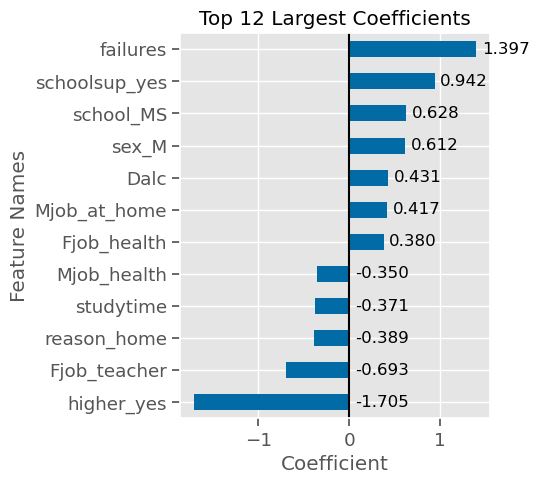

In [39]:
ax = plot_coeffs(coeffs,top_n=12,annotate=True)



In our figure above, we have both positive and negative coefficients.

Positive values indicate the feature makes it more likely the student will fail (class==True)

Negative values indicate the feature makes it less likely the student will fail.

If you look closely, we actually have some values that are larger than +1 or less than -1. But we said that logistic regression returns a probability less than 1?
So what is going on? What are these coefficient values?

In order for us to explain the logistic regression coefficients in plain English, we first need to convert the log-odds into odds.

## Converting Log-Odds to Odds

To convert our log-odds coefficients into odds, we need to take the Euler number (the math constant e = 2.718281) and raise it to the power of our coefficient (e**coeff).

In [40]:
## logodds coeff for failures
coeffs.loc['failures']



1.3969901603800474

In [41]:
## Raising e to the power of our logodds coeff 
import math
math.e**coeffs.loc['failures']



4.043012815203985

This returns the "odds" of being in the positive class (in our case - the odds of failing vs passing).

By using np.exp(), we can do this to our entire series at once:

In [42]:
coeffs_odds = np.exp(coeffs)
plot_coeffs(coeffs_odds)


In [43]:
#Updating our function
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0, 
                      as_odds=False):
    
    if feature_names is None:
        feature_names = logreg.feature_names_in_
        
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    # use .loc to add the intercept to the series
    coeffs.loc['intercept'] = logreg.intercept_[class_index]
        
    if as_odds==True:
        coeffs = np.exp(coeffs)
    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)
    
        
    return coeffs



In [44]:
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
coeffs_odds



higher_yes             0.181852
Fjob_teacher           0.500238
reason_home            0.677910
studytime              0.689810
Mjob_health            0.704448
traveltime             0.713937
address_U              0.722915
Fjob_at_home           0.738703
famrel                 0.773755
age                    0.802339
Fedu                   0.806122
Mjob_other             0.821392
activities_yes         0.829739
Medu                   0.829817
guardian_father        0.867182
Walc                   0.889046
nursery_yes            0.923536
internet_yes           0.929263
guardian_mother        0.947610
reason_reputation      1.002609
Mjob_services          1.016893
absences               1.075016
freetime               1.107435
Mjob_teacher           1.122096
goout                  1.130187
paid_yes               1.133607
health                 1.142106
famsize_LE3            1.148222
famsup_yes             1.148451
reason_course          1.183199
romantic_yes           1.211665
Pstatus_

## Interpreting Odds

Odds are how much more likely to fall into the 1 class than the 0 class.

- A value of 1 means both classes are equally likely.

- A value > 1 means that the 1 class is more likely than the 0 class.

- A value < 1 means that the 1 class is less likely than the 0 class.

You've likely encountered odds in real world situations/conversations.

"What are the odds that horse A will win the race over horse B?"

In other words, how many times more likely is horse A to win vs horse B?

In [45]:
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
coeffs_odds






higher_yes             0.181852
Fjob_teacher           0.500238
reason_home            0.677910
studytime              0.689810
Mjob_health            0.704448
traveltime             0.713937
address_U              0.722915
Fjob_at_home           0.738703
famrel                 0.773755
age                    0.802339
Fedu                   0.806122
Mjob_other             0.821392
activities_yes         0.829739
Medu                   0.829817
guardian_father        0.867182
Walc                   0.889046
nursery_yes            0.923536
internet_yes           0.929263
guardian_mother        0.947610
reason_reputation      1.002609
Mjob_services          1.016893
absences               1.075016
freetime               1.107435
Mjob_teacher           1.122096
goout                  1.130187
paid_yes               1.133607
health                 1.142106
famsize_LE3            1.148222
famsup_yes             1.148451
reason_course          1.183199
romantic_yes           1.211665
Pstatus_

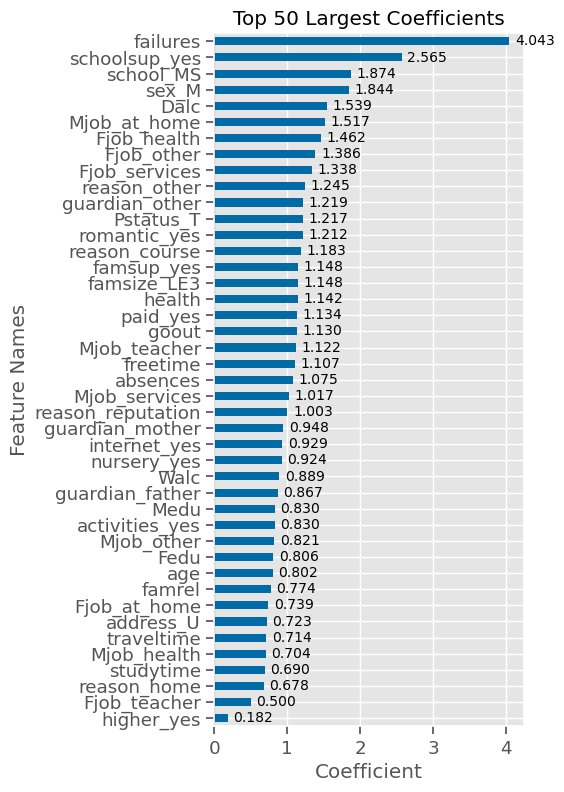

In [46]:
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
ax = plot_coeffs(coeffs_odds,top_n=50,annotate=True, figsize=(4,9),size=10)






## Interpreting Odds Coefficients

“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) (when all other variables are held constant).”

Let's walk through interpreting some of our largest odds coefficients:

failures:
For every additional failure, the odds of a student failing is 4.043 times the odds of passing.

schoolsup_yes:
Getting (needing?) extra support from the school increases the odds of failing by 2.566

school_MS:
students who attend MS (and not GP) are 1.873 times more likely to fail.

sex_M:
male students are 1.844 times more likely to fail than female students.


Note About Odds being Positive

Now that we have odds coefficients, we no longer have any negative values.

This means that any of our negative log-odds coefficients (that decreased the chances of the failing) are now odds values less than 1.

In other words, we can no longer use the magnitude of the coefficients to determine the most impactful, since a very small coefficient will still represent a big change.

Looking back at our smallest odds coefficients, we can see that:

higher_yes:
students who intended to pursue higher education are .18 times more likely to fail (meaning they are much less likely to fail).
Or we could say that these students are .18 times less likely to fail.

Fjob_teacher:
having a father who is a teacher decreases the odds of failing by .5.

reason_home:
attending the school because its close to their home decreases the odds of failing by .678 times.

## Presenting Logistic Regression Coefficients to Non-Technical Stakeholders

To help us digest and interpret the coefficients better, let's add a vertical line at 1 (where 1= equally likely of Failing or Passing).

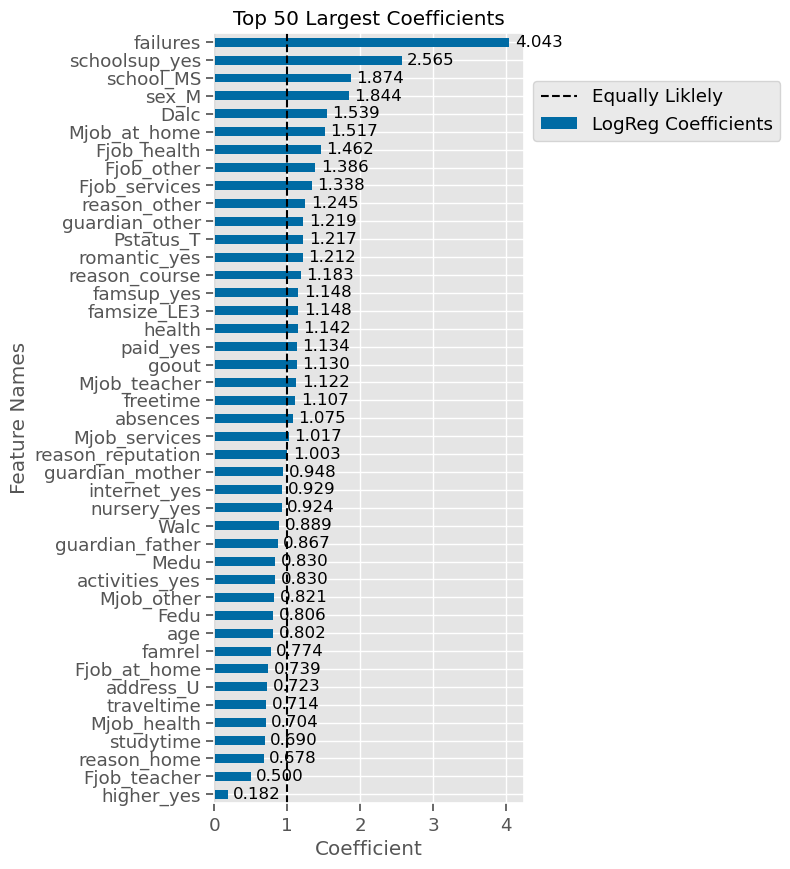

In [47]:
ax = plot_coeffs(coeffs_odds,top_n=50, annotate= True,figsize=(4,10))
ax.axvline(1, ls='--',label='Equally Liklely',color='k', zorder=1)
ax.legend(bbox_to_anchor=[1,.95])






When presenting a summary of your model's findings to a non-technical stakeholder, you can choose which version of the coefficients you show.


Depending on your comfort level for interpreting odds, you may want to leave the coefficients as log-odds to get a nice/clean positive value for each feature.

## Visualizing Odds Coefficients more effectively.

If you are comfortable explaining odds and use color-coding and/or a vertical line indicating the threshold between more/less likely, then using odds coefficients may work better for you.

To aid in the visual interpretation of Odds, we can color-code the values greater than 1 and less than 1.


In [48]:
colors_dict = {}
for i in coeffs_odds.index:
    rounded_coeff = np.round( coeffs_odds.loc[i],3)
    if rounded_coeff < 1:
        color = 'darkred'
    
    elif rounded_coeff> 1:
        color = 'forestgreen'
    else:
        color='gray'
    colors_dict[i] = color
        
## previewing example >1 and <1
colors_dict['age'],colors_dict['higher_yes']



('darkred', 'darkred')

In [49]:
def get_colors_gt_lt(coeffs, threshold=1, color_lt ='darkred',
                     color_gt='forestgreen', color_else='gray'):
    """Creates a dictionary of features:colors based on if value is > or < threshold"""
    colors_dict = {}
    for i in coeffs.index:
        rounded_coeff = np.round( coeffs.loc[i],3)
        if rounded_coeff < threshold:
            color = color_lt
        elif rounded_coeff > threshold:
            color = color_gt
        else:
            color=color_else
        colors_dict[i] = color
    return colors_dict



In [50]:
def plot_coeffs_color(coeffs, top_n=None,  figsize=(8,6), legend_loc='best',threshold=None, color_lt='darkred', color_gt='forestgreen', color_else='gray', label_thresh='Equally Likely', label_gt='More Likely', label_lt='Less Likely', plot_kws = {}):
    if top_n is None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        ## plotting top N importances
    if threshold is not None:
        color_dict = get_colors_gt_lt(plot_vals, threshold=threshold,
                                      color_gt=color_gt,color_lt=color_lt,
                                      color_else=color_else)
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        plot_kws.update({'color':colors})
    
    
    ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    
    if threshold is not None:
        ln1 = ax.axvline(threshold,ls=':',color='black')
        from matplotlib.patches import Patch
        box_lt = Patch(color=color_lt)
        box_gt = Patch(color=color_gt)
        handles = [ln1,box_gt,box_lt]
        labels = [label_thresh,label_gt,label_lt]
        ax.legend(handles,labels, loc=legend_loc)
    ## return ax in case want to continue to update/modify figure
    return ax



# SHAP model 

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



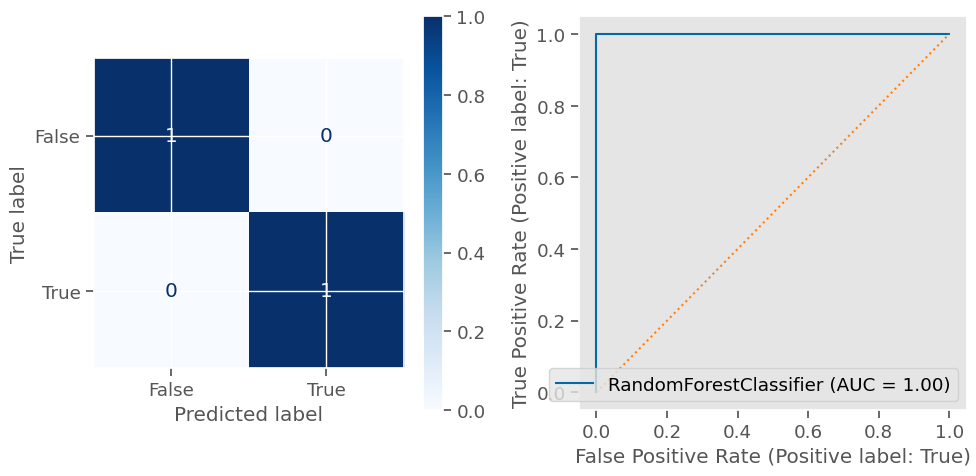

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



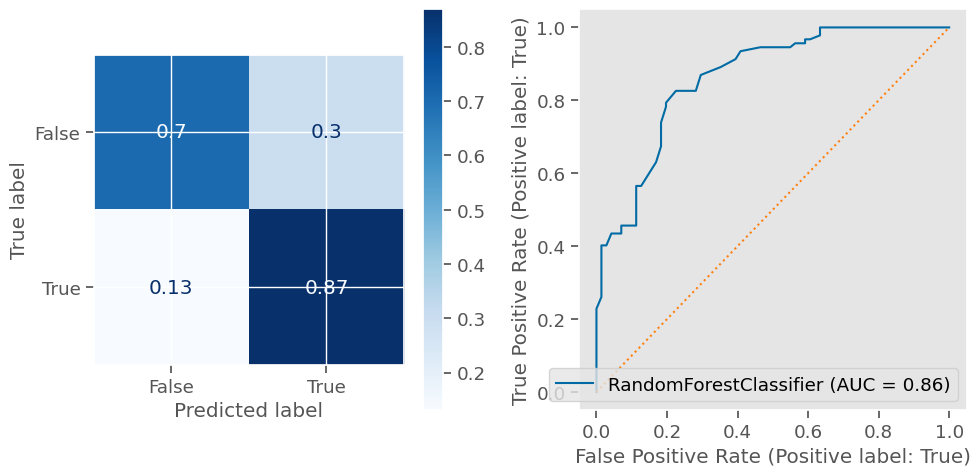

In [52]:
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)


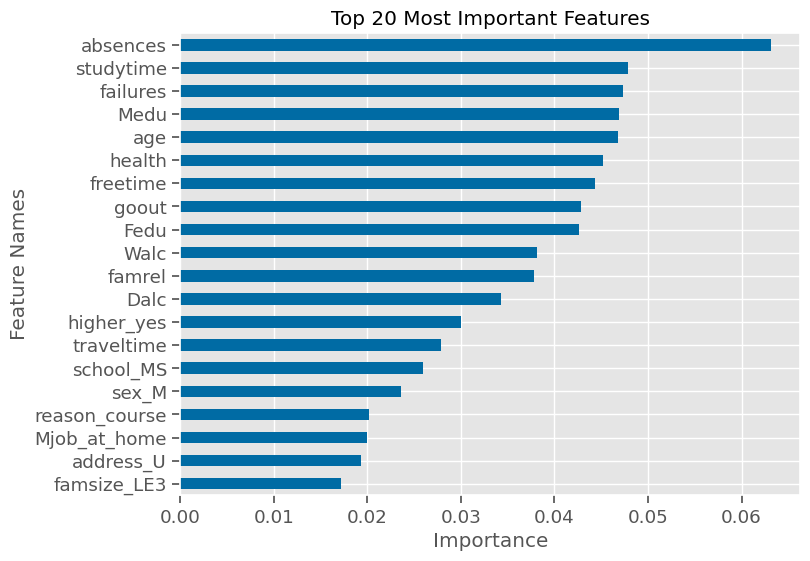

In [53]:
rf_importances = get_importances(rf_clf)
plot_importance(rf_importances,top_n=20);



## Preparing Data for Shap

In [56]:
len(X_train_df)



486

486 may be fine, or it could be a bit much for your local machine.
Whenever the dataset is too large for your machine to process in a timely manner, we can use SHAP's utility for sampling a subset of our data (shap.sample).
Let's take just 400 observations from our X_train_df and save it as X_shap.

In [57]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap.head()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [58]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 


473     True
340    False
452     True
555    False
70      True
       ...  
485     True
329    False
251     True
434     True
568     True
Name: target_F, Length: 400, dtype: bool

## 1. Create a SHAP explainer using your fit model

In [59]:
explainer = shap.Explainer(rf_clf)
explainer



The explainer will use a copy of our model to iterate through all of the features to calculate the marginal contribution of each feature to the model's predictions.

These contributions will be represented as SHAP values, which we will interpret to explain our model.

## 2. Get SHAP values from explainer for your training data

In [60]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)


shap._explanation.Explanation

In [61]:
# let's remember the shape of the sample of X values we provided to our explainer
X_shap.shape



(400, 43)

In [62]:
# let's investigate the shape of our shap_values
shap_values.shape



(400, 43, 2)

Notice that the 3rd dimension is 2.
This is because our classification task has 2 classes. If we had more classes, we would have the same number in our third dimension as we have classes.
We actually have two SHAP values for every sample and feature (one for each target class)

## Exploring SHAP Explanation Values

In [63]:
# This is the result for just one sample (in our case, one student) from our dataset.
shap_values[0]


.values =
array([[-1.15165368e-02,  1.15165368e-02],
       [-2.00970183e-02,  2.00970183e-02],
       [-3.73278511e-02,  3.73278511e-02],
       [-1.30577180e-02,  1.30577180e-02],
       [-6.02032650e-02,  6.02032650e-02],
       [ 1.82659012e-02, -1.82659012e-02],
       [-2.60672307e-02,  2.60672307e-02],
       [-5.23592261e-03,  5.23592261e-03],
       [-1.03872516e-02,  1.03872516e-02],
       [-2.83196172e-02,  2.83196172e-02],
       [-2.07484363e-02,  2.07484363e-02],
       [-5.73616057e-03,  5.73616057e-03],
       [-1.13086674e-02,  1.13086674e-02],
       [-4.39675434e-02,  4.39675434e-02],
       [-3.55386270e-02,  3.55386270e-02],
       [ 1.27171520e-03, -1.27171520e-03],
       [-5.32930678e-03,  5.32930678e-03],
       [-2.30715695e-03,  2.30715695e-03],
       [-4.69512766e-02,  4.69512766e-02],
       [-1.45327285e-03,  1.45327285e-03],
       [-5.67660591e-03,  5.67660591e-03],
       [-3.72593331e-04,  3.72593331e-04],
       [-2.87157566e-03,  2.87157566e-03],
 

values: the SHAP values calculated for this observation/row.

base_values: the baseline SHAP value without features, (you can think of this similar to an intercept)

data: the original input features




    
    

Since our stakeholders have been interested in predicting and understanding students who fail, we can simplify our third dimension to just include the SHAP values for 1 (failing).

Since the 3rd dimension of our SHAP explanations is the target class (Failing is index 1), we will want to slice out all rows, all columns, and index=1 for the final dimension.

In [64]:
## Brenda: which name to use?
# shap_vals_fail = shap_values[:,:,1]
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape


(400, 43)

In [65]:
pd.DataFrame(shap_vals_1.values, columns = X_shap.columns)



,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0.011517,0.020097,0.037328,0.013058,0.060203,-0.018266,0.026067,0.005236,0.010387,0.028320,0.020748,0.005736,0.011309,0.043968,0.035539,-0.001272,0.005329,0.002307,0.046951,0.001453,0.005677,0.000373,0.002872,-0.000225,0.000057,-0.001143,0.000815,0.005247,0.015226,0.004208,-0.001029,0.007523,0.000662,0.001909,0.000386,-0.001690,0.007628,-0.000286,0.002959,-0.001125,-0.010127,-0.000757,-0.001594
1,-0.027303,-0.009091,-0.031383,-0.010162,0.049549,-0.033083,-0.014626,-0.004118,0.003253,-0.031235,0.004435,0.017833,-0.049344,-0.040682,0.025022,-0.011379,-0.003799,0.002595,-0.017070,-0.035362,-0.001404,-0.003323,-0.007938,-0.001239,-0.001395,-0.010251,-0.006474,0.003280,-0.015919,-0.028659,-0.004538,0.004828,-0.003888,-0.007049,0.000052,-0.006882,0.005054,-0.004694,-0.004045,-0.008982,-0.023219,-0.001126,-0.002661
2,0.017169,0.032987,0.019626,-0.015481,0.007520,-0.026687,-0.007202,0.025579,0.040698,-0.015929,0.001173,0.003841,0.025080,0.080948,-0.011251,0.038092,0.007363,0.001380,-0.007668,0.002596,-0.005117,0.001234,0.003561,-0.000647,-0.000297,0.021454,0.013906,0.004540,0.027574,0.004750,-0.001471,0.007297,0.004914,0.005234,-0.000168,-0.001349,0.007637,-0.000833,0.007627,0.004793,-0.014682,0.000407,-0.006618
3,0.001809,-0.001358,-0.001983,0.008710,-0.099199,-0.034132,-0.010260,-0.004445,-0.006709,-0.023644,-0.010326,-0.008269,0.007948,0.008614,-0.017645,-0.004299,-0.001429,0.001784,-0.011344,0.001983,-0.005672,-0.001386,-0.000014,-0.000376,-0.001226,0.005254,0.002630,0.001950,-0.022413,-0.033509,-0.004206,-0.005627,-0.008104,-0.006877,-0.001257,0.010184,-0.002114,-0.001120,0.000369,-0.008371,-0.018657,-0.017193,0.005509
4,0.023117,0.035304,0.043111,0.002672,-0.006079,-0.025589,0.000259,0.027685,-0.012348,-0.006155,-0.003187,0.038435,0.014096,-0.001177,0.052577,-0.004504,-0.000448,0.004517,-0.001922,0.003276,0.005726,0.001250,0.002838,0.000213,-0.000518,0.014882,0.004071,0.003847,-0.005173,0.007281,-0.000556,-0.010176,0.011737,0.022177,-0.000538,-0.005201,0.006749,-0.001681,0.017924,-0.002532,-0.014325,0.000894,0.001052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.005944,0.032713,0.010837,0.017512,0.015403,-0.029194,-0.008268,0.002200,0.033450,-0.012353,-0.001753,0.003920,-0.033018,0.076793,-0.018266,0.044056,0.004954,0.003984,0.049728,0.004451,0.009985,0.006397,0.003805,-0.000098,0.000057,0.006940,0.001221,0.003836,0.026492,0.006006,-0.000313,0.004812,0.004523,0.001943,-0.000272,-0.002883,0.011984,-0.000758,-0.000626,0.000846,-0.015745,-0.000426,-0.005350
396,-0.032286,0.007996,-0.006788,-0.004848,-0.028363,-0.036994,-0.019997,0.003082,-0.010410,-0.025484,-0.019203,0.013089,0.035533,-0.035958,-0.025918,-0.019437,-0.001882,0.002458,-0.013930,0.003163,-0.018483,-0.005339,0.000345,-0.000950,-0.000626,0.001183,-0.000436,0.001897,0.004315,-0.002029,-0.001586,0.007717,-0.001411,-0.002327,-0.001202,-0.006209,-0.004485,-0.001636,-0.002966,-0.009947,-0.019903,-0.008036,-0.018128
397,0.022906,0.043701,0.045876,0.008123,0.065592,-0.020319,-0.007152,0.059772,-0.015232,-0.008339,0.005327,0.051061,0.011300,-0.023666,0.002258,0.000582,0.002345,-0.000007,-0.007452,0.003360,0.000645,0.002900,0.001926,0.000280,-0.000540,0.003650,0.005691,0.002209,0.004935,-0.011772,-0.001979,0.011892,0.000771,0.002492,0.000673,-0.003171,-0.004975,-0.000165,0.010768,-0.001453,-0.016682,0.001947,0.013505
398,0.011959,0.013783,0.016340,-0.002397,-0.047356,-0.021644,0.065

## Summary Plot - Bar

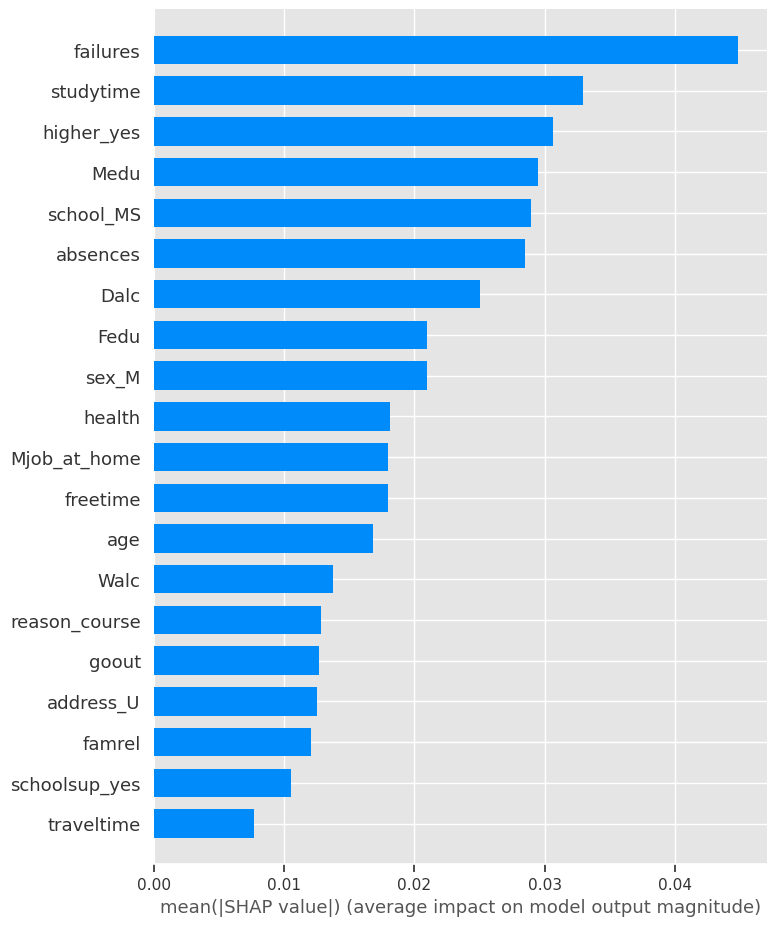

In [66]:
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='bar')



The bar plot summary shows the average of the SHAP value for each feature across all samples.

Let's remind ourselves what our random forest calculated as the feature importances, and compare the results.

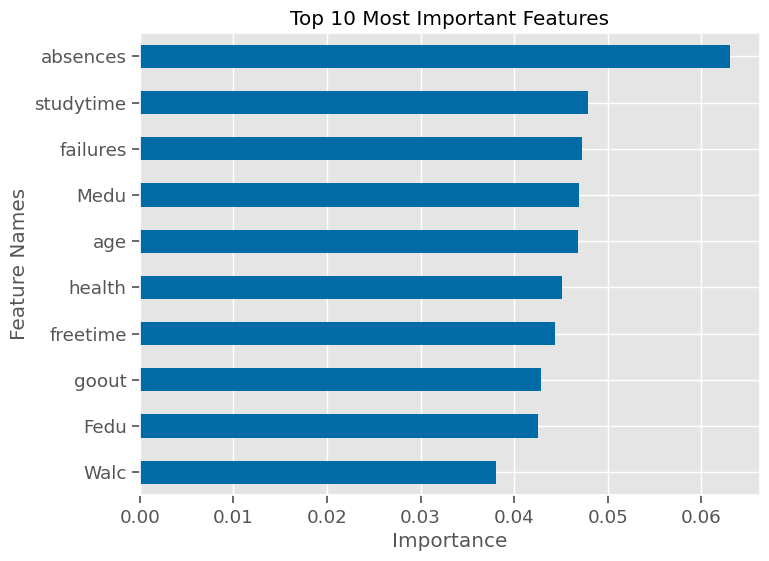

In [67]:
plot_importance(rf_importances,top_n=10);



Let's also remind ourselves of the permutation importances we calculated for the model.

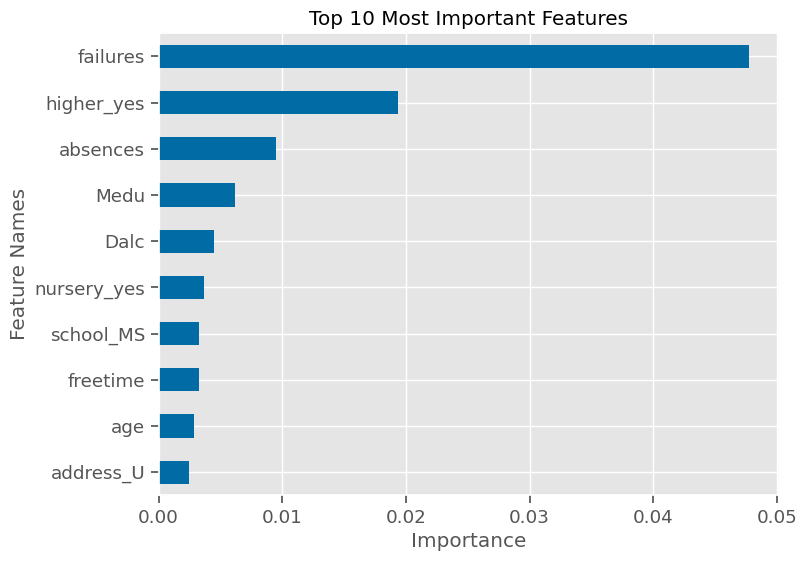

In [68]:
plot_importance(rf_perm_importances,top_n=10);



As we can see above, SHAP's importances differ from the built-in random forest importances.
It is also different from the permutation importances. However, the permutation importances and SHAP importances shared similar important features that were undervalued by the random forest (e.g. higher_yes).
Like feature importance and permutation importance, this visualization is not indicating which direction the features push the prediction.
Let's remove the plot_type='bar' argument and examine the default plot type that will provide this information.

## Summary Plot - dot (default)

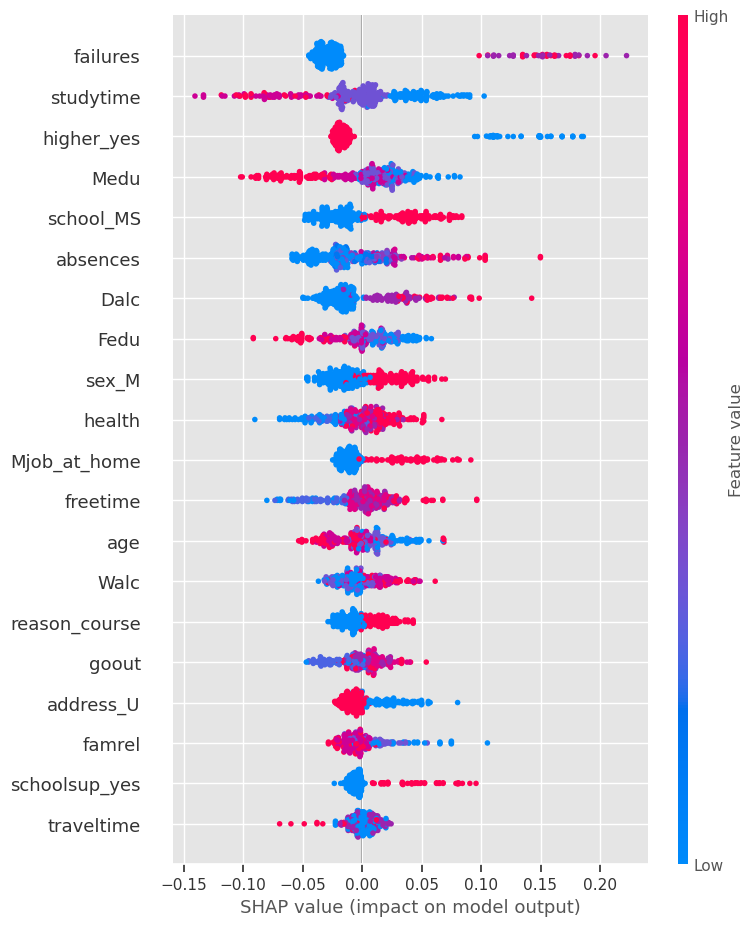

In [71]:
shap.summary_plot(shap_vals_1,X_shap, plot_type='dot')



Let's just follow the red dots for each feature. Red means the feature value is higher.

If the red is on the right (positive), higher values of this feature increase the chance the prediction will be fail.

If the red is on the left (negative), higher values of this feature decrease the chances the prediction will be fail.

 According to our model, higher values for failures increases the chance of failing Portuguese, whereas, higher values for higher_yes (1 since it is categorical) decreases the chance of failing.
 
 
 ##### Failures - 
 
 Because red values are on the right (positive), we can see that the greater the number of failures a student had, the more likely the model would predict the student will Fail
 
 ##### studytime - 
 
 Because the red dots are on the left (negative) we can see that the higher the study time, the less likely the model will predict the student will fail.

##### higher_yes

The red values are on the left (negative) so that if higher_yes==1 (meaning the student wants to pursue higher education), then the model is much LESS likely to predict failure.

 If higher_yes==0 (the blue dots), the model is more likely to predict the student will fail